In [1]:
import os
import PIL
import glob
import wandb
import random

import numpy as np
import pandas as pd
import seaborn as sns
import typing as tp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

import torchvision
import torchvision.models as models
import torchvision.transforms.v2 as transforms

from dataclasses import dataclass
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset

wandb.require('core')

wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [3]:
class SignDataset(data.Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Инициализация набора данных.

        :param dataframe: DataFrame, содержащий пути к изображениям и соответствующие метки.
        :param transform: Опциональный параметр для преобразования изображений.
        """
        self.imlist = dataframe  # Сохраняем DataFrame с путями к изображениям и метками
        self.transform = transform  # Сохраняем функцию преобразования изображений, если она предоставлена

    def __getitem__(self, index):
        """
        Получение элемента набора данных по индексу.

        :param index: Индекс элемента в наборе данных.
        :return: Преобразованное изображение, метка и путь к изображению.
        """
        impath, target = self.imlist.loc[index]  # Получаем путь к изображению и метку по индексу

        # Проверяем существование файла по указанному пути
        if not os.path.exists(impath):
            print('No file', impath)  # Выводим сообщение, если файл не существует
            pass  # Пропускаем текущую итерацию, если файл не найден

        # Открываем изображение и преобразуем его в формат RGB
        img = PIL.Image.open(impath).convert('RGB')

        # Применяем преобразование к изображению, если оно предоставлено
        if self.transform:
            img = self.transform(img)

        # Возвращаем преобразованное изображение, метку и путь к изображению
        return img, target, impath

    def __len__(self):
        """
        Возвращает количество элементов в наборе данных.

        :return: Количество элементов в наборе данных.
        """
        return len(self.imlist)  # Возвращаем длину DataFrame, которая соответствует количеству изображений

In [4]:
all_train_files = sorted(glob.glob(r'Данные\signs\TRAIN\*\*'))
all_test_files = sorted(glob.glob(r'Данные\signs\TEST\*\*'))

In [5]:
all_train_files = [x.replace('\\', '/') for x in all_train_files]
all_test_files = [x.replace('\\', '/') for x in all_test_files]
train_classes = [int(x.split('/')[-2]) for x in all_train_files]
test_classes = [int(x.split('/')[-2]) for x in all_test_files]

In [6]:
train_df = pd.DataFrame(zip(all_train_files, train_classes), columns=['im_name', 'class'])
test_df = pd.DataFrame(zip(all_test_files, test_classes), columns=['im_name', 'class'])

In [7]:
train_df

,im_name,class
0,Данные/signs/TRAIN/0/000_0001.png,0
1,Данные/signs/TRAIN/0/000_0002.png,0
2,Данные/signs/TRAIN/0/000_0003.png,0
3,Данные/signs/TRAIN/0/000_0004.png,0
4,Данные/signs/TRAIN/0/000_0005.png,0
...,...,...
1787,Данные/signs/TRAIN/9/010_0031.png,9
1788,Данные/signs/TRAIN/9/010_0031_j.png,9
1789,Данные/signs/TRAIN/9/010_0032.png,9
1790,Данные/signs/TRAIN/9/010_0033.png,9


In [8]:
counts_train = train_df.groupby('class')['im_name'].count().reset_index()
counts_test = test_df.groupby('class')['im_name'].count().reset_index()

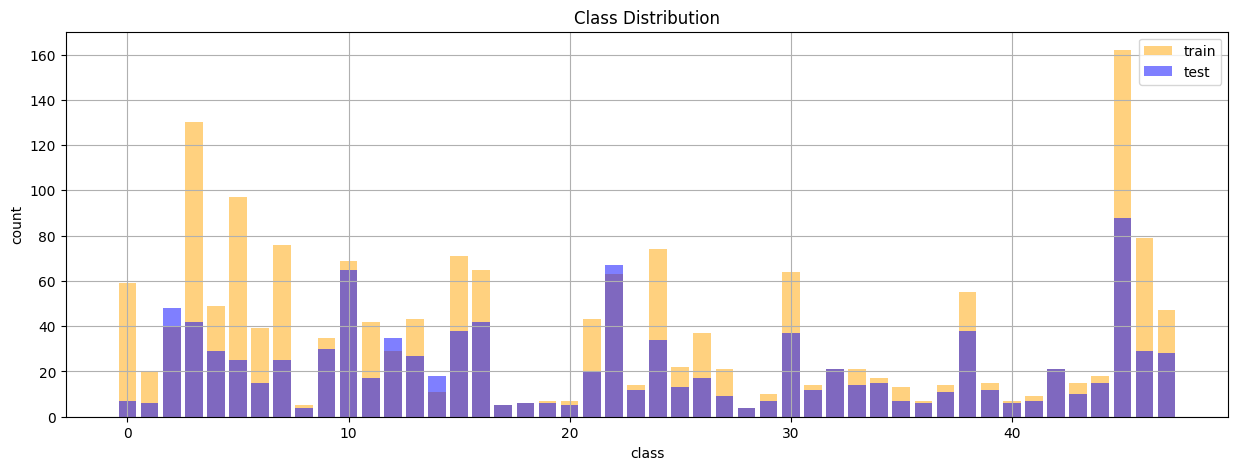

In [9]:
plt.figure(figsize=(15, 5))
plt.xlabel('class')
plt.ylabel('count')
plt.title('Class Distribution')
plt.bar(counts_train['class'], counts_train['im_name'], color='orange', alpha=0.5, label='train')
plt.bar(counts_test['class'], counts_test['im_name'], color='blue', alpha=0.5, label='test')
plt.legend()
plt.grid()
plt.show()

In [10]:
def myshow(img):
    img = img * 0.3 + 0.3
    npimg = img.detach().numpy()          # Преобразование в NumPy и отключение от графов
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(npimg.transpose(1, 2, 0))  # Преобразуем тензор в массив NumPy и меняем порядок осей

In [11]:
# Функция для включения детерминированности в PyTorch
def enable_determinism():
    # Устанавливаем переменную окружения для конфигурации рабочего пространства cuBLAS
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    # Используем детерминированные алгоритмы в PyTorch
    torch.use_deterministic_algorithms(True)

# Функция для фиксации начальных значений генераторов случайных чисел
def fix_seeds(seed):
    # Фиксируем начальное значение для генератора случайных чисел NumPy
    np.random.seed(seed)
    # Фиксируем начальное значение для генератора случайных чисел Python
    random.seed(seed)
    # Фиксируем начальное значение для генератора случайных чисел PyTorch на CPU
    torch.manual_seed(seed)
    # Фиксируем начальное значение для генератора случайных чисел PyTorch на GPU
    torch.cuda.manual_seed(seed)

# Функция для фиксации начальных значений генераторов случайных чисел в рабочих процессах DataLoader
def seed_worker(_):
    # Получаем начальное значение для рабочего процесса
    worker_seed = torch.initial_seed() % 2**32
    # Фиксируем начальное значение для генератора случайных чисел NumPy
    np.random.seed(worker_seed)
    # Фиксируем начальное значение для генератора случайных чисел Python
    random.seed(worker_seed)

In [12]:
def run_epoch(epoch, net, loader, criterion, optimizer, device, is_train):
    if is_train:
        net.train()
    else:
        net.eval()

    running_loss = 0.0
    correct = 0.0
    total = 0.0
    all_preds = []
    all_labels = []

    for i, data in enumerate(loader):
        images, labels, _ = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        all_preds = np.concatenate((all_preds, predicted.cpu().numpy()))
        all_labels = np.concatenate((all_labels, labels.cpu().numpy()))

    acc = (all_preds == all_labels).sum() / len(all_preds)
    ball_acc = balanced_accuracy_score(all_labels, all_preds)

    print(f'Loss: {running_loss / (i + 1):.3f}, accuracy: {acc * 100.0:.3f}, balanced_acc: {ball_acc * 100.0:.3f}')

    if is_train:
        wandb.log({'train loss': running_loss / (i + 1)}, step=epoch)
        wandb.log({'train accuracy': acc * 100.0}, step=epoch)
        wandb.log({'train balanced_acc': ball_acc * 100.0}, step=epoch)
    else:
        wandb.log({'test loss': running_loss / (i + 1)}, step=epoch)
        wandb.log({'test accuracy': acc * 100.0}, step=epoch)
        wandb.log({'test balanced_acc': ball_acc * 100.0}, step=epoch)

    return all_preds, all_labels

In [13]:
@dataclass
class Config:
    seed: int = 42

    batch_size: int = 32
    img_size: int = 64

    n_epochs: int = 10
    lr: float = 1e-4

In [14]:
config = Config()
enable_determinism()
fix_seeds(config.seed)
generator = torch.Generator()
generator.manual_seed(config.seed)

In [15]:
# Определяем последовательность преобразований для изображений
transform = transforms.Compose([
    # Изменяем размер изображения до 64x64 пикселей с антиалиасингом
    transforms.Resize((config.img_size, config.img_size), antialias=True),
    # Преобразуем изображение PIL в тензор
    transforms.PILToTensor(),
    # Преобразуем тензор в тип данных float32 и масштабируем значения пикселей в диапазон [0, 1]
    transforms.ToDtype(dtype=torch.float32, scale=True),
    # Нормализуем тензор с использованием средних значений и стандартных отклонений для каждого канала
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
])

# Создаем объекты датасетов для обучения и тестирования
train_dataset = SignDataset(dataframe=train_df, transform=transform)
test_dataset = SignDataset(dataframe=test_df, transform=transform)

# Создаем DataLoader для обучающего датасета
train_loader = DataLoader(
    train_dataset,  # Датасет для обучения
    batch_size=config.batch_size,  # Размер батча
    num_workers=6,  # Количество рабочих процессов для загрузки данных
    shuffle=True,   # Перемешивание данных
    pin_memory=True,  # Использование закрепленной памяти для более быстрой загрузки данных
    drop_last=True,  # Игнорирование последнего батча, если он меньше указанного размера
    worker_init_fn=seed_worker,  # Функция инициализации рабочих процессов для фиксации начальных значений
    generator=generator  # Генератор для детерминированного порядка данных
)

# Создаем DataLoader для тестового датасета
test_loader = DataLoader(
    test_dataset,  # Датасет для тестирования
    batch_size=config.batch_size,  # Размер батча
    num_workers=6,  # Количество рабочих процессов для загрузки данных
    pin_memory=True,  # Использование закрепленной памяти для более быстрой загрузки данных
)

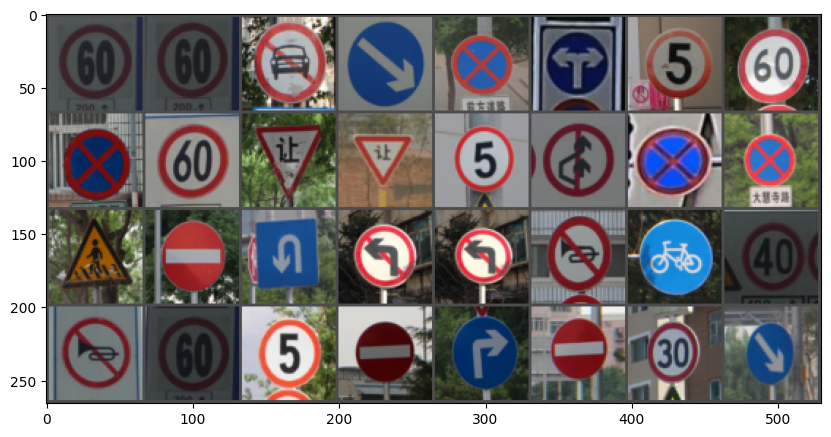

In [16]:
images, labels, impaths = next(iter(train_loader))
myshow(torchvision.utils.make_grid(images))

# Default ResNet50

In [17]:
net = models.resnet50(weights='DEFAULT')
net.fc = nn.Linear(net.fc.in_features, 48)
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)
criterion = nn.CrossEntropyLoss()

In [18]:
wandb.init(
    project='lesson-3-CV',
    name='default-resnet_50',
    config=config.__dict__
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gorbatovs1997 (gorbatovs-banking) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [19]:
for epoch in range(config.n_epochs):
    # train
    print(f'Training epoch: {epoch + 1} / {config.n_epochs}')
    _, _ = run_epoch(epoch, net, train_loader, criterion, optimizer, device, is_train=True)

    # validation
    print(f'Validation')
    with torch.no_grad():
        _, _ = run_epoch(epoch, net, test_loader, criterion, optimizer, device, is_train=False)

    print('--------------------------------')

wandb.finish()

Training epoch: 1 / 10
Loss: 2.925, accuracy: 39.844, balanced_acc: 23.805
Validation
Loss: 2.456, accuracy: 44.360, balanced_acc: 27.361
--------------------------------
Training epoch: 2 / 10
Loss: 0.862, accuracy: 81.585, balanced_acc: 58.218
Validation
Loss: 1.367, accuracy: 65.213, balanced_acc: 52.299
--------------------------------
Training epoch: 3 / 10
Loss: 0.228, accuracy: 95.815, balanced_acc: 86.077
Validation
Loss: 0.950, accuracy: 74.218, balanced_acc: 65.080
--------------------------------
Training epoch: 4 / 10
Loss: 0.095, accuracy: 98.493, balanced_acc: 96.274
Validation
Loss: 0.882, accuracy: 74.597, balanced_acc: 68.057
--------------------------------
Training epoch: 5 / 10
Loss: 0.036, accuracy: 99.665, balanced_acc: 99.107
Validation
Loss: 0.809, accuracy: 77.346, balanced_acc: 70.290
--------------------------------
Training epoch: 6 / 10
Loss: 0.022, accuracy: 99.777, balanced_acc: 99.581
Validation
Loss: 0.780, accuracy: 78.863, balanced_acc: 73.659
-------

test accuracy,▁▅▆▇▇▇█▇██
test balanced_acc,▁▄▆▇▇▇████
test loss,█▄▂▂▂▂▁▁▁▁
train accuracy,▁▆████████
train balanced_acc,▁▄▇███████
train loss,█▃▂▁▁▁▁▁▁▁
test accuracy,82.36967
test balanced_acc,77.63034
test loss,0.64409
train accuracy,99.88839
train balanced_acc,99.82323


# TrivialAugment

In [13]:
@dataclass
class Config:
    seed: int = 42
    batch_size: int = 32
    img_size: int = 64
    n_epochs: int = 10
    lr: float = 1e-4

config = Config()
enable_determinism()
fix_seeds(config.seed)
generator = torch.Generator()
generator.manual_seed(config.seed)

In [14]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=(config.img_size, config.img_size), scale=(0.5, 1.0), antialias=True),
    transforms.TrivialAugmentWide(),
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
])

transform_test = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size), antialias=True),
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
])

In [15]:
train_dataset = SignDataset(dataframe=train_df, transform=transform_train)
test_dataset = SignDataset(dataframe=test_df, transform=transform_test)


train_loader = DataLoader(
    train_dataset, 
    batch_size=config.batch_size,
    num_workers=0,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    worker_init_fn=seed_worker,
    generator=generator
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    num_workers=0,
    pin_memory=True,
)

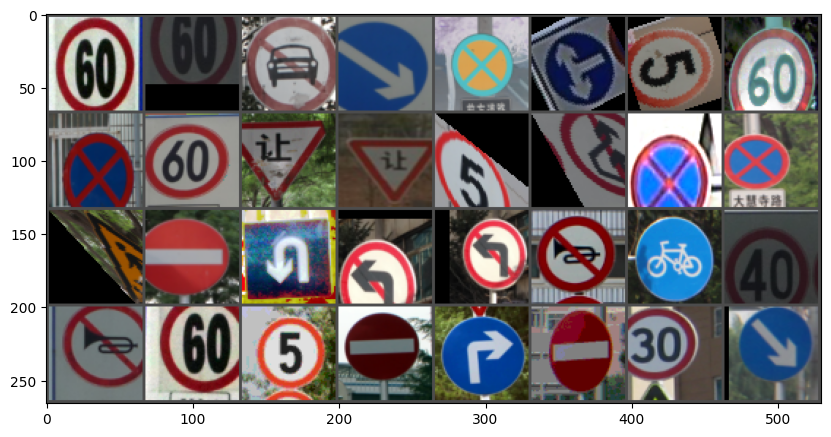

In [16]:
images, labels, impaths = next(iter(train_loader))
myshow(torchvision.utils.make_grid(images))

In [17]:
net = models.resnet50(weights='DEFAULT')
net.fc = nn.Linear(net.fc.in_features, 48)
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)
criterion = nn.CrossEntropyLoss()

wandb.init(
    project='lesson-3-CV',
    name='trivial_aug',
    config=config.__dict__
)

for epoch in range(config.n_epochs):
    # train
    print(f'Training epoch: {epoch + 1} / {config.n_epochs}')
    _, _ = run_epoch(epoch, net, train_loader, criterion, optimizer, device, is_train=True)

    # validation
    print(f'Validation')
    with torch.no_grad():
        _, _ = run_epoch(epoch, net, test_loader, criterion, optimizer, device, is_train=False)

    print('--------------------------------')

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gorbatovs1997 (gorbatovs-banking) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training epoch: 1 / 10
Loss: 3.331, accuracy: 24.275, balanced_acc: 11.824
Validation
Loss: 2.837, accuracy: 36.588, balanced_acc: 21.109
--------------------------------
Training epoch: 2 / 10
Loss: 1.725, accuracy: 60.714, balanced_acc: 32.602
Validation
Loss: 1.743, accuracy: 52.891, balanced_acc: 33.441
--------------------------------
Training epoch: 3 / 10
Loss: 0.865, accuracy: 78.125, balanced_acc: 51.941
Validation
Loss: 1.167, accuracy: 67.488, balanced_acc: 52.272
--------------------------------
Training epoch: 4 / 10
Loss: 0.534, accuracy: 86.496, balanced_acc: 66.038
Validation
Loss: 0.904, accuracy: 73.175, balanced_acc: 61.974
--------------------------------
Training epoch: 5 / 10
Loss: 0.393, accuracy: 89.174, balanced_acc: 75.702
Validation
Loss: 0.702, accuracy: 77.346, balanced_acc: 68.009
--------------------------------
Training epoch: 6 / 10
Loss: 0.306, accuracy: 91.908, balanced_acc: 83.239
Validation
Loss: 0.640, accuracy: 80.569, balanced_acc: 75.006
-------

test accuracy,▁▃▅▆▇▇████
test balanced_acc,▁▂▅▆▆▇████
test loss,█▅▃▂▂▂▁▁▁▁
train accuracy,▁▅▆▇▇█████
train balanced_acc,▁▃▄▆▇▇▇███
train loss,█▄▃▂▂▁▁▁▁▁
test accuracy,85.40284
test balanced_acc,82.10512
test loss,0.46052
train accuracy,96.14955
train balanced_acc,92.9963


# RandomErasing

In [13]:
@dataclass
class Config:
    seed: int = 42
    batch_size: int = 32
    img_size: int = 64
    n_epochs: int = 10
    lr: float = 1e-4

config = Config()
enable_determinism()
fix_seeds(config.seed)
generator = torch.Generator()
generator.manual_seed(config.seed)

In [14]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=(config.img_size, config.img_size), scale=(0.5, 1.0), antialias=True),
    transforms.TrivialAugmentWide(),
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3]),
    transforms.RandomErasing(),
])

transform_test = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size), antialias=True),
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
])

In [15]:
train_dataset = SignDataset(dataframe=train_df, transform=transform_train)
test_dataset = SignDataset(dataframe=test_df, transform=transform_test)


train_loader = DataLoader(
    train_dataset, 
    batch_size=config.batch_size,
    num_workers=0,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    worker_init_fn=seed_worker,
    generator=generator
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    num_workers=0,
    pin_memory=True,
)

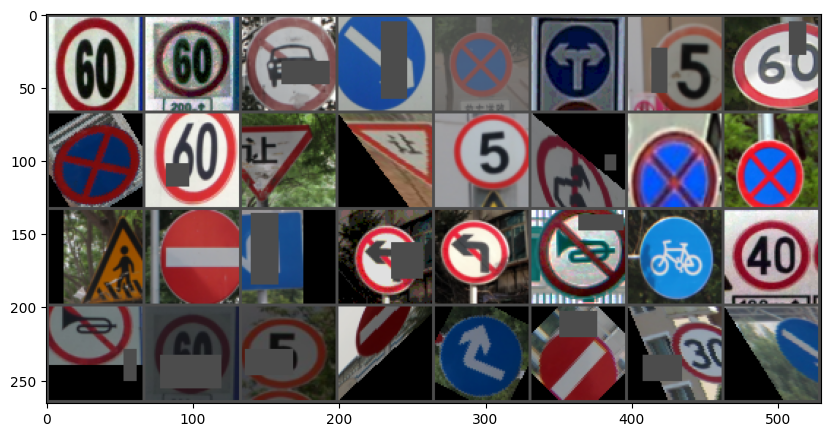

In [16]:
images, labels, impaths = next(iter(train_loader))
myshow(torchvision.utils.make_grid(images))

In [17]:
net = models.resnet50(weights='DEFAULT')
net.fc = nn.Linear(net.fc.in_features, 48)
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)
criterion = nn.CrossEntropyLoss()

wandb.init(
    project='lesson-3-CV',
    name='random_erasing',
    config=config.__dict__
)

for epoch in range(config.n_epochs):
    # train
    print(f'Training epoch: {epoch + 1} / {config.n_epochs}')
    _, _ = run_epoch(epoch, net, train_loader, criterion, optimizer, device, is_train=True)

    # validation
    print(f'Validation')
    with torch.no_grad():
        _, _ = run_epoch(epoch, net, test_loader, criterion, optimizer, device, is_train=False)

    print('--------------------------------')

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gorbatovs1997 (gorbatovs-banking) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training epoch: 1 / 10
Loss: 3.389, accuracy: 20.592, balanced_acc: 9.826
Validation
Loss: 2.814, accuracy: 34.597, balanced_acc: 20.728
--------------------------------
Training epoch: 2 / 10
Loss: 1.933, accuracy: 55.022, balanced_acc: 30.282
Validation
Loss: 1.752, accuracy: 54.028, balanced_acc: 36.050
--------------------------------
Training epoch: 3 / 10
Loss: 1.095, accuracy: 72.098, balanced_acc: 46.606
Validation
Loss: 1.254, accuracy: 64.076, balanced_acc: 48.028
--------------------------------
Training epoch: 4 / 10
Loss: 0.750, accuracy: 79.632, balanced_acc: 58.008
Validation
Loss: 0.972, accuracy: 69.953, balanced_acc: 56.875
--------------------------------
Training epoch: 5 / 10
Loss: 0.580, accuracy: 84.375, balanced_acc: 69.344
Validation
Loss: 0.854, accuracy: 74.787, balanced_acc: 64.792
--------------------------------
Training epoch: 6 / 10
Loss: 0.502, accuracy: 85.379, balanced_acc: 72.363
Validation
Loss: 0.796, accuracy: 75.735, balanced_acc: 66.851
--------

test accuracy,▁▄▅▆▇▇████
test balanced_acc,▁▃▄▅▆▇████
test loss,█▅▃▂▂▂▁▁▁▁
train accuracy,▁▄▆▇▇▇████
train balanced_acc,▁▃▄▅▆▇▇███
train loss,█▅▃▂▂▁▁▁▁▁
test accuracy,81.70616
test balanced_acc,77.86988
test loss,0.626
train accuracy,91.79688
train balanced_acc,86.461


# Long Training

In [18]:
@dataclass
class Config:
    seed: int = 42
    batch_size: int = 32
    img_size: int = 64
    n_epochs: int = 15
    lr: float = 1e-4

config = Config()
enable_determinism()
fix_seeds(config.seed)
generator = torch.Generator()
generator.manual_seed(config.seed)

In [19]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=(config.img_size, config.img_size), scale=(0.5, 1.0), antialias=True),
    transforms.TrivialAugmentWide(),
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3]),
    transforms.RandomErasing(),
])

transform_test = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size), antialias=True),
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
])

In [20]:
net = models.resnet50(weights='DEFAULT')
net.fc = nn.Linear(net.fc.in_features, 48)
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)
criterion = nn.CrossEntropyLoss()

wandb.init(
    project='lesson-3-CV',
    name='trivial_aug_random_erasing_longer',
    config=config.__dict__
)

for epoch in range(config.n_epochs):
    # train
    print(f'Training epoch: {epoch + 1} / {config.n_epochs}')
    _, _ = run_epoch(epoch, net, train_loader, criterion, optimizer, device, is_train=True)

    # validation
    print(f'Validation')
    with torch.no_grad():
        _, _ = run_epoch(epoch, net, test_loader, criterion, optimizer, device, is_train=False)

    print('--------------------------------')

wandb.finish()

Training epoch: 1 / 15
Loss: 3.399, accuracy: 21.429, balanced_acc: 10.537
Validation
Loss: 2.765, accuracy: 36.209, balanced_acc: 20.005
--------------------------------
Training epoch: 2 / 15
Loss: 1.887, accuracy: 56.083, balanced_acc: 30.465
Validation
Loss: 1.706, accuracy: 59.242, balanced_acc: 38.789
--------------------------------
Training epoch: 3 / 15
Loss: 1.076, accuracy: 72.321, balanced_acc: 46.740
Validation
Loss: 1.147, accuracy: 68.720, balanced_acc: 52.459
--------------------------------
Training epoch: 4 / 15
Loss: 0.753, accuracy: 78.739, balanced_acc: 59.263
Validation
Loss: 0.901, accuracy: 71.564, balanced_acc: 57.737
--------------------------------
Training epoch: 5 / 15
Loss: 0.583, accuracy: 83.482, balanced_acc: 66.036
Validation
Loss: 0.700, accuracy: 80.284, balanced_acc: 68.910
--------------------------------
Training epoch: 6 / 15
Loss: 0.469, accuracy: 86.328, balanced_acc: 74.121
Validation
Loss: 0.604, accuracy: 81.043, balanced_acc: 74.937
-------

test accuracy,▁▄▅▆▇▇▇▇▇██████
test balanced_acc,▁▃▅▅▆▇▇▇▇██████
test loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁
train accuracy,▁▄▆▇▇▇▇████████
train balanced_acc,▁▃▄▅▆▇▇▇▇██████
train loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
test accuracy,87.109
test balanced_acc,83.64034
test loss,0.38719
train accuracy,93.30357
train balanced_acc,91.0894


# Настройка Scheduler

## Step scheduler

In [21]:
@dataclass
class Config:
    seed: int = 42
    batch_size: int = 32
    img_size: int = 64
    n_epochs: int = 15
    lr: float = 1e-4
    scheduler_type: tp.Literal['exp', 'step', 'cosine'] | None = 'step'

config = Config()
enable_determinism()
fix_seeds(config.seed)
generator = torch.Generator()
generator.manual_seed(config.seed)

In [22]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=(config.img_size, config.img_size), scale=(0.5, 1.0), antialias=True),
    transforms.TrivialAugmentWide(),
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3]),
    transforms.RandomErasing(),
])

transform_test = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size), antialias=True),
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
])

In [25]:
def get_scheduler(config, optimizer, step=None, gamma=None):
    if config.scheduler_type == 'exp':
        return optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    if config.scheduler_type == 'step':
        return optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma)
    if config.scheduler_type == 'cosine':
        T_max = config.n_epochs * len(train_loader)
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)
    else:
        return None

In [26]:
net = models.resnet50(weights='DEFAULT')
net.fc = nn.Linear(net.fc.in_features, 48)
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)
criterion = nn.CrossEntropyLoss()

scheduler = get_scheduler(config, optimizer, step=11, gamma=0.1)

In [27]:
def run_epoch_v2(epoch, net, loader, criterion, optimizer, scheduler, device, is_train):
    if is_train:
        net.train()
    else:
        net.eval()

    running_loss = 0.0
    correct = 0.0
    total = 0.0
    all_preds = []
    all_labels = []

    for i, data in enumerate(loader):
        images, labels, _ = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # если scheduler задан cosine
            if (scheduler is not None) and (config.scheduler_type == 'cosine'):
                scheduler.step()
                lr = scheduler.get_last_lr()[0]

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        all_preds = np.concatenate((all_preds, predicted.cpu().numpy()))
        all_labels = np.concatenate((all_labels, labels.cpu().numpy()))

    acc = (all_preds == all_labels).sum() / len(all_preds)
    ball_acc = balanced_accuracy_score(all_labels, all_preds)

    print(f'Loss: {running_loss / (i + 1):.3f}, accuracy: {acc * 100.0:.3f}, balanced_acc: {ball_acc * 100.0:.3f}')

    
    if is_train:
        
        # если scheduler задан и он НЕ cosine
        if (scheduler is not None) and (config.scheduler_type != 'cosine'):
            scheduler.step()
            lr = scheduler.get_last_lr()[0]

        wandb.log({'lr': lr}, step=epoch)
        wandb.log({'train loss': running_loss / (i + 1)}, step=epoch)
        wandb.log({'train accuracy': acc * 100.0}, step=epoch)
        wandb.log({'train balanced_acc': ball_acc * 100.0}, step=epoch)
    else:
        wandb.log({'test loss': running_loss / (i + 1)}, step=epoch)
        wandb.log({'test accuracy': acc * 100.0}, step=epoch)
        wandb.log({'test balanced_acc': ball_acc * 100.0}, step=epoch)

    return all_preds, all_labels

In [28]:
wandb.init(
    project='lesson-3-CV',
    name='step_scheduler',
    config=config.__dict__
)

for epoch in range(config.n_epochs):
    # train
    print(f'Training epoch: {epoch + 1} / {config.n_epochs}')
    _, _ = run_epoch(epoch, net, train_loader, criterion, optimizer, device, is_train=True)

    # validation
    print(f'Validation')
    with torch.no_grad():
        _, _ = run_epoch(epoch, net, test_loader, criterion, optimizer, device, is_train=False)

    print('--------------------------------')

wandb.finish()

Training epoch: 1 / 15
Loss: 3.389, accuracy: 20.592, balanced_acc: 9.863
Validation
Loss: 2.772, accuracy: 32.038, balanced_acc: 18.470
--------------------------------
Training epoch: 2 / 15
Loss: 1.929, accuracy: 55.413, balanced_acc: 28.899
Validation
Loss: 1.720, accuracy: 53.081, balanced_acc: 34.509
--------------------------------
Training epoch: 3 / 15
Loss: 1.150, accuracy: 69.754, balanced_acc: 44.462
Validation
Loss: 1.193, accuracy: 65.687, balanced_acc: 51.343
--------------------------------
Training epoch: 4 / 15
Loss: 0.796, accuracy: 78.125, balanced_acc: 58.364
Validation
Loss: 0.921, accuracy: 71.469, balanced_acc: 58.299
--------------------------------
Training epoch: 5 / 15
Loss: 0.600, accuracy: 82.924, balanced_acc: 66.213
Validation
Loss: 0.807, accuracy: 74.976, balanced_acc: 63.673
--------------------------------
Training epoch: 6 / 15
Loss: 0.512, accuracy: 85.603, balanced_acc: 71.944
Validation
Loss: 0.718, accuracy: 77.536, balanced_acc: 70.895
--------

test accuracy,▁▄▆▆▇▇█▇███████
test balanced_acc,▁▃▄▅▆▇▇▇▇▇▇████
test loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,▁▄▆▇▇▇█████████
train balanced_acc,▁▃▄▅▆▆▇▇▇██████
train loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
test accuracy,83.88626
test balanced_acc,82.90514
test loss,0.52049
train accuracy,92.80134
train balanced_acc,90.31522


## Cosine scheduler

In [29]:
@dataclass
class Config:
    seed: int = 42
    batch_size: int = 32
    img_size: int = 64
    n_epochs: int = 15
    lr: float = 1e-4
    scheduler_type: tp.Literal['exp', 'step', 'cosine'] | None = 'cosine'

config = Config()
enable_determinism()
fix_seeds(config.seed)
generator = torch.Generator()
generator.manual_seed(config.seed)

In [30]:
net = models.resnet50(weights='DEFAULT')
net.fc = nn.Linear(net.fc.in_features, 48)
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)
criterion = nn.CrossEntropyLoss()

scheduler = get_scheduler(config, optimizer)

In [31]:
wandb.init(
    project='lesson-3-CV',
    name='cosine_scheduler',
    config=config.__dict__
)

for epoch in range(config.n_epochs):
    # train
    print(f'Training epoch: {epoch + 1} / {config.n_epochs}')
    _, _ = run_epoch(epoch, net, train_loader, criterion, optimizer, device, is_train=True)

    # validation
    print(f'Validation')
    with torch.no_grad():
        _, _ = run_epoch(epoch, net, test_loader, criterion, optimizer, device, is_train=False)

    print('--------------------------------')

wandb.finish()

Training epoch: 1 / 15
Loss: 3.345, accuracy: 22.879, balanced_acc: 11.211
Validation
Loss: 2.731, accuracy: 38.199, balanced_acc: 21.696
--------------------------------
Training epoch: 2 / 15
Loss: 1.913, accuracy: 55.692, balanced_acc: 29.527
Validation
Loss: 1.681, accuracy: 58.957, balanced_acc: 38.756
--------------------------------
Training epoch: 3 / 15
Loss: 1.156, accuracy: 69.587, balanced_acc: 44.577
Validation
Loss: 1.150, accuracy: 66.445, balanced_acc: 50.892
--------------------------------
Training epoch: 4 / 15
Loss: 0.751, accuracy: 79.408, balanced_acc: 58.806
Validation
Loss: 0.871, accuracy: 72.701, balanced_acc: 58.593
--------------------------------
Training epoch: 5 / 15
Loss: 0.539, accuracy: 84.319, balanced_acc: 67.996
Validation
Loss: 0.745, accuracy: 75.450, balanced_acc: 65.430
--------------------------------
Training epoch: 6 / 15
Loss: 0.495, accuracy: 84.933, balanced_acc: 71.466
Validation
Loss: 0.608, accuracy: 81.517, balanced_acc: 72.258
-------

test accuracy,▁▄▅▆▆▇█▇▇██████
test balanced_acc,▁▃▄▅▆▇▇▇▇██████
test loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,▁▄▆▇▇▇▇████████
train balanced_acc,▁▃▄▅▆▆▇▇▇██████
train loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
test accuracy,85.87678
test balanced_acc,82.38723
test loss,0.45068
train accuracy,92.96875
train balanced_acc,90.57654


## Cosine scheduler с большим LR

In [32]:
@dataclass
class Config:
    seed: int = 42
    batch_size: int = 32
    img_size: int = 64
    n_epochs: int = 15
    lr: float = 1e-3
    scheduler_type: tp.Literal['exp', 'step', 'cosine'] | None = 'cosine'

config = Config()
enable_determinism()
fix_seeds(config.seed)
generator = torch.Generator()
generator.manual_seed(config.seed)

In [33]:
net = models.resnet50(weights='DEFAULT')
net.fc = nn.Linear(net.fc.in_features, 48)
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)
criterion = nn.CrossEntropyLoss()

scheduler = get_scheduler(config, optimizer)

In [34]:
wandb.init(
    project='lesson-3-CV',
    name='cosine_scheduler_big_lr',
    config=config.__dict__
)

for epoch in range(config.n_epochs):
    # train
    print(f'Training epoch: {epoch + 1} / {config.n_epochs}')
    _, _ = run_epoch(epoch, net, train_loader, criterion, optimizer, device, is_train=True)

    # validation
    print(f'Validation')
    with torch.no_grad():
        _, _ = run_epoch(epoch, net, test_loader, criterion, optimizer, device, is_train=False)

    print('--------------------------------')

wandb.finish()

Training epoch: 1 / 15
Loss: 2.041, accuracy: 48.996, balanced_acc: 28.965
Validation
Loss: 1.864, accuracy: 54.976, balanced_acc: 39.295
--------------------------------
Training epoch: 2 / 15
Loss: 0.920, accuracy: 73.717, balanced_acc: 54.245
Validation
Loss: 1.059, accuracy: 69.953, balanced_acc: 57.381
--------------------------------
Training epoch: 3 / 15
Loss: 0.743, accuracy: 77.232, balanced_acc: 60.767
Validation
Loss: 0.898, accuracy: 73.555, balanced_acc: 63.794
--------------------------------
Training epoch: 4 / 15
Loss: 0.663, accuracy: 81.641, balanced_acc: 69.857
Validation
Loss: 0.735, accuracy: 79.052, balanced_acc: 71.769
--------------------------------
Training epoch: 5 / 15
Loss: 0.577, accuracy: 83.147, balanced_acc: 72.700
Validation
Loss: 0.604, accuracy: 82.559, balanced_acc: 78.052
--------------------------------
Training epoch: 6 / 15
Loss: 0.527, accuracy: 83.873, balanced_acc: 75.198
Validation
Loss: 0.946, accuracy: 75.071, balanced_acc: 72.987
-------

test accuracy,▁▄▅▆▇▅▅▇▇▇▇▇███
test balanced_acc,▁▄▄▆▆▆▅▇▇▇▇▇██▇
test loss,█▄▃▃▂▄▆▂▁▂▂▂▁▁▁
train accuracy,▁▅▆▇▇▇▇▇▇██████
train balanced_acc,▁▄▅▆▇▇▇▇▇▇█████
train loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
test accuracy,87.48815
test balanced_acc,84.26044
test loss,0.46704
train accuracy,89.67634
train balanced_acc,84.41554


# Оптимизатор AdamW

In [35]:
@dataclass
class Config:
    seed: int = 42
    batch_size: int = 32
    img_size: int = 64
    n_epochs: int = 15
    lr: float = 1e-3
    scheduler_type: tp.Literal['exp', 'step', 'cosine'] | None = 'cosine'

config = Config()
enable_determinism()
fix_seeds(config.seed)
generator = torch.Generator()
generator.manual_seed(config.seed)

In [36]:
net = models.resnet50(weights='DEFAULT')
net.fc = nn.Linear(net.fc.in_features, 48)
net = net.to(device)

optimizer = torch.optim.AdamW(net.parameters(), lr=config.lr)
criterion = nn.CrossEntropyLoss()

scheduler = get_scheduler(config, optimizer)

In [37]:
wandb.init(
    project='lesson-3-CV',
    name='cosine_scheduler_big_lr_AdamW',
    config=config.__dict__
)

for epoch in range(config.n_epochs):
    # train
    print(f'Training epoch: {epoch + 1} / {config.n_epochs}')
    _, _ = run_epoch(epoch, net, train_loader, criterion, optimizer, device, is_train=True)

    # validation
    print(f'Validation')
    with torch.no_grad():
        _, _ = run_epoch(epoch, net, test_loader, criterion, optimizer, device, is_train=False)

    print('--------------------------------')

wandb.finish()

Training epoch: 1 / 15
Loss: 1.963, accuracy: 50.670, balanced_acc: 29.738
Validation
Loss: 0.995, accuracy: 70.427, balanced_acc: 52.444
--------------------------------
Training epoch: 2 / 15
Loss: 0.840, accuracy: 74.888, balanced_acc: 56.665
Validation
Loss: 0.706, accuracy: 78.673, balanced_acc: 69.931
--------------------------------
Training epoch: 3 / 15
Loss: 0.715, accuracy: 79.018, balanced_acc: 67.397
Validation
Loss: 0.765, accuracy: 77.630, balanced_acc: 71.945
--------------------------------
Training epoch: 4 / 15
Loss: 0.539, accuracy: 83.984, balanced_acc: 72.921
Validation
Loss: 0.863, accuracy: 78.768, balanced_acc: 73.490
--------------------------------
Training epoch: 5 / 15
Loss: 0.526, accuracy: 84.710, balanced_acc: 75.073
Validation
Loss: 0.569, accuracy: 84.076, balanced_acc: 77.159
--------------------------------
Training epoch: 6 / 15
Loss: 0.484, accuracy: 85.435, balanced_acc: 78.404
Validation
Loss: 0.662, accuracy: 79.810, balanced_acc: 75.660
-------

test accuracy,▁▄▄▄▆▅▇▆▆▇▇███▇
test balanced_acc,▁▅▅▅▆▆▇▆▆▇▇█▇██
test loss,█▅▅▆▃▄▃▃▃▃▃▁▂▂▃
train accuracy,▁▅▆▇▇▇▇▇███████
train balanced_acc,▁▄▆▆▇▇▇▇▇▇▇████
train loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
test accuracy,84.36019
test balanced_acc,84.25105
test loss,0.55883
train accuracy,89.78795
train balanced_acc,83.76548
